# Graph Neural Network
---
> Graph neural network model for vertex dynamics and tension prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies, HaraAblation
from simgnn.train import train_model, write_log, load_log, predict, predict_batch
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Training

- Use `simgnn.transforms` to normalise real--Hara movies and ablation,  and simulated movies. Use same normalisation constants for all simulated movies.
- For ablation movies, convert to  HaraMovies length scale (pixels) and use same `l_av` as for HaraMovies dataset.

|Dataset | Details | Shortname| Avg. edge len.| Transforms (Normalisation)|
|:---:|:---|:---|---:|:---|
|Synthetic datasets     | vertex dynamics simulations| "train" and "val"| 1.0 a.u.| `[Pos2Vec(scale=10*1.0)`,`ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)`,`ScalePressure(0.33,shift=0.1)]`|
|Hara Movies  | no force information       | "hara"| 26.32 pixels|`[Pos2Vec(scale=10*26.32)`, `ScaleVelocity(0.5*26.32)]`|
|Hara Ablation| short movies w/ recoil data| "abln"| 26.32*0.4/0.21 pixels| `[Pos2Vec(scale=10*50.13), ScaleVelocity(0.5*50.13)]` (frame rate:dataset contains vertex positions only from every 10th frame) |


### Datasets

In [5]:
# !rm -dr simgnn_data/single_distr_sims/train/processed
# !rm -dr simgnn_data/single_distr_sims/val/processed
# !rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
# !rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed
# !rm -dr simgnn_data/hara_movies/processed
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/
# !rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed/

!rm -dr simgnn_data/hara_movies/processed/
!rm -dr simgnn_data/hara_ablation/processed/

rm: simgnn_data/unimodal_wbasetens_sims/train/processed: No such file or directory
rm: simgnn_data/unimodal_wbasetens_sims/val/processed: No such file or directory


In [5]:
!ls simgnn_data

cell2node.png	    hara_movies			 single_distr_sims
edge_tracking_gifs  hara_movies_as_sep_datasets  unimodal_wbasetens_sims
expmodulation_sims  saved_models
hara_ablation	    simulation_gifs


In [13]:
window_size = 5

# Normalisation: for simulated data (simul params ~ normal distr-s): l0=1.0, Hara_movie: l0=26.32
Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) , ScaleVelocity(0.5*1.0),
                   ScaleTension(0.634, shift=0.6), ScalePressure(0.33, shift=0.1 ), Reshape_x((-1,window_size*2)) ] )
Tnorm_hara = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32), Reshape_x((-1,window_size*2))]) # Hara movie dataset norm
Tnorm_abln = T.Compose([Pos2Vec(scale=10*50.21), ScaleVelocity(0.5*50.21), Reshape_x((-1,window_size*2))]) # Hara ablation norm

hara_abln = HaraAblation('simgnn_data/hara_ablation/', window_size=window_size, transform=Tnorm_abln)

# Hara movie datasets
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

# Simulation datasets
# sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, transform=Tnorm) # rand base contractility
# sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size, transform=Tnorm)
# sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorm) # no base contractility
# sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size, transform=Tnorm)

# datasets_dict = {'train': seg001[:20],#sim1,
#                  'val': sim1_val,
#                  'val2' : sim2_val,
#                  'early' : seg001[-5:],
#                  'mid'   : seg003[-5:],
#                  'late'  : seg005[-5:],
#                 'raw': seg001_raw[len(seg001_raw)//3-1-5:len(seg001_raw)//3-1]}
# dataset_legend={'train': 'Train (Hara:early)',
#                 'val': 'Sim(Non-zero)',
#                 'val2': 'Sim(Zero)',
#                'early': 'Hara (early)',
#                 'mid': 'Hara(mid)',
#                 'late': 'Hara(late)',
#                'raw': 'Hara(early:raw)'}

# datasets_dict = {'train': sim1,
#                  'val': sim2,
#                  'early' : seg001[-5:],
#                  'mid'   : seg003[-5:],
#                  'late'  : seg005[-5:]}
# dataset_legend={'train': 'Train (sim1)',
#                 'val': 'Val(sim2)',
#                 'early': 'Hara (early)',
#                 'mid': 'Hara(mid)',
#                 'late': 'Hara(late)'}

train : HaraMovies(20)
size:20

Frame 1:
CellData(cell2node_index=[2, 492], edge_attr=[225, 2], edge_index=[2, 225], node2cell_index=[2, 492], pos=[164, 2], x=[164, 10], y=[164, 2])


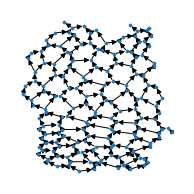

In [113]:
k='train'
print('{} : {}\nsize:{}\n\nFrame 1:\n{}'.format(k,datasets_dict[k],len(datasets_dict[k]),datasets_dict[k][0]))
plt.figure(figsize=[2.5,2.5])
nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

#### Helper functions

In [114]:
def plot_losses(train_log, loaders, dataset_legend,figsize=[15,8]):
    if figsize is not None:
        plt.figure(figsize=figsize)
    training_epochs = np.arange(train_log['total_epochs'])
    for data_name in loaders:
        plt.plot(training_epochs, train_log[f'{data_name}_loss_tot'],lw=3,label=f'{dataset_legend[data_name]}')
    plt.legend();


def plot_velocity_predictions(vel_pred, vel_tgt, dataset_legend, figsize=[15,7]):
    var_type = 0
    var_name = '$\Delta{}x$'

    for data_name in vel_pred:
        minY, maxY  = torch.cat(vel_tgt[data_name],dim=0).min(), torch.cat(vel_tgt[data_name],dim=0).max()

        fig,axs = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=figsize)    
        for k,ax in enumerate(axs):
            ax.plot([minY,maxY], [minY,maxY],'--',color='b',lw=2,alpha=.5)
            ax.plot(torch.cat(vel_tgt[data_name], dim=0)[:,k],
                    torch.cat(vel_pred[data_name], dim=0)[:,k], 'o',ms=10,mfc='tomato',alpha=.25)
            ax.set_xlabel('True');
            ax.set_ylabel('Predicted')
            ax.set_title(f'{var_name}$_{k}$');
        plt.suptitle(f'{dataset_legend[data_name]}')
        plt.show()

#### Persistence Loss

In [115]:
print('Persistence:')
for k in datasets_dict:
    print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')

Persistence:
	- Train (Hara:early): {'mae': 0.026774133, 'mse': 0.0012163394}
	- Sim(Non-zero): {'mae': 0.06426177, 'mse': 0.007703601}
	- Sim(Zero): {'mae': 0.063635536, 'mse': 0.008163488}
	- Hara (early): {'mae': 0.028903184, 'mse': 0.0013524193}
	- Hara(mid): {'mae': 0.021136116, 'mse': 0.00074782554}
	- Hara(late): {'mae': 0.018739773, 'mse': 0.0005740396}
	- Hara(early:raw): {'mae': 0.04471593, 'mse': 0.00466818}


In [21]:
len(datasets_dict['train'])

280

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

**To-Do**👷🚧
- need a func-n w/ a **rollout error**,
- convert vel-y error to **position error**
- *Training loop*:
    - [ ] Combine `Message` and `AggregateUpdate` into a graph layer `GraphBlock`
- [ ] Write *prediction stage*: read \{test, val, train\} data for rollout error measurements.
- [ ] Experiments (**save all models** w/ backups; will need to test on the real tensions)<br>
*Params*: edge attrib-s, cell layer, arch(skip con-s), input noise (for long term prediction). *Errors*: 1-step, and rollout error (check after training at test time).
    1. Experiment with GN arch-s w/ *residual* (w/ skip) and *non-residual* architectures.
    1. *Edge directions experiment*: train w/ and w/o edge dir-s, do edge dir-s help to speed up training?
    1. *Cell layer*: does having dedicated cell processing layer help to increase the accuracy?
    1. For best (resnet or non-resnet) run *number of layers and dim-n sizes*. Try deep nets, how does accuracy change with increasing the depth of the net?
    1. If resnet is better: try w/and w/o edge dir-s and "cell layers".
    1. Number of previous velocities (window size).
    1. Rollout experiment 1— *input noise*: according to Sanchez-Gonzalez, *et al.* \[ASG2020\], Brownian noise improves rollout accuracies (long term accuracy of the whole movie, and/or prediction stability/robustness).
    1. Rollout experiment 2— *rollout training*: train directly on rollout, i.e. use 5- and 10-step loss instead of a 1-step loss for training (slower training).
    1. Optional:
        - compare MLP vs CONV layers for message passing.
        - try with dynamic graphs (construct graphs on the fly based on relative positions, and use cell edges and cell attrib only for queries on `Y_edge`, `Y_cell`).
- [ ] Ablation dataset (*real*).

---
**DOING**🛠
1. Construct graph net without skip connections.
1. Combine Message and AggregateUpdate into a graph layer GraphNet (GN) block, a more general block, that can be composed into a deep residual network. "AddGN" block, w/ `AddGN(x) = f(x)+x` form (in fact, where it's possible make all blocks with this form.
1. Construct residual net out of GNs.
---

- **Examples**:
    - General "Message Passing" schemes: a nice example for composite graph layer –"meta layer" consisting of "edge", "node" and "global" layers [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

---
- **Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

---